# Autoregressive Residual Neural Network

This notebook is a JAX implementation of the Autoregressive Residual Neural Network model to solve the Kuramoto-Sivashinsky equation. The code combines the autoregressive model with the residual neural network to solve the Kuramoto-Sivashinsky equation.

## Importing the necessary libraries

In [90]:
import jax 
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

## Seting the constants

In [91]:
DOMAIN_SIZE = 100.00
NUM_DOF = 256
DT = 0.2

NUM_SAMPLES_TRAIN = 60
TRAIN_TEMPORAL_HORIZON = 100
NUM_WARMUP_STEPS = 800

NUM_SAMPLES_TEST = 30
TEST_TEMPORAL_HORIZON = 200

## Creating the dataset

The KS dataset will come from the notebook file 'DataGenerator.ipynb'.

In [92]:
# Create the class to solve the KS equation
class KsEtd2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [93]:
ks_etdrk2_stepper = KsEtd2(DOMAIN_SIZE, NUM_DOF, DT)

In [94]:
u_0 = jax.random.normal(jax.random.PRNGKey(0), (NUM_SAMPLES_TRAIN,1,NUM_DOF))

# u_0 = jax.vmap(lambda u: u - jnp.mean(u))(u_0)

u_0.shape

(60, 1, 256)

In [95]:
def rollout(
        stepper_fn,
        n,
        *,
        include_init = False,
    ):

    """Transform an autonomous timestepper into a function that efficiently unrolls a trajectory."""
    def scan_fn(u, _):
        u_next = stepper_fn(u)
        return u_next, u_next

    def rollout_fn(init):
        _,history = jax.lax.scan(scan_fn, init, None, length=n)

        if include_init:
            return jnp.concatenate([init[None], history], axis=0)
        else:
            return history
    
    return rollout_fn
    

In [96]:
trj_with_warmpu = jax.vmap(rollout(ks_etdrk2_stepper, TRAIN_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True))(u_0)

trj_with_warmpu.shape

(60, 901, 1, 256)

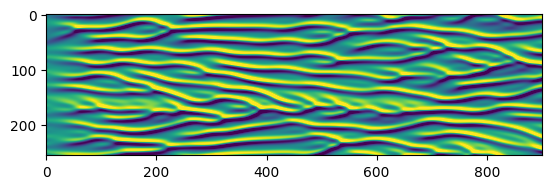

In [97]:
plt.imshow(trj_with_warmpu[1,:,0,:].T, cmap='viridis',vmin=-2,vmax=2)

(60, 101, 1, 256)


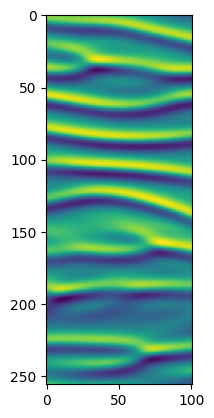

In [98]:
trj = trj_with_warmpu[:,NUM_WARMUP_STEPS:,:,:]

plt.imshow(trj[0,:,0,:].T, cmap='viridis')
print(trj.shape)


In [99]:
u_0_teste = jax.random.normal(jax.random.PRNGKey(0), (NUM_SAMPLES_TEST,1,NUM_DOF))

u_0_teste = jax.vmap(lambda u: u - jnp.mean(u))(u_0_teste)

u_0_teste.shape

(30, 1, 256)

In [100]:
trj_test = jax.vmap(rollout(ks_etdrk2_stepper, TEST_TEMPORAL_HORIZON + NUM_WARMUP_STEPS, include_init=True))(u_0_teste)[:,NUM_WARMUP_STEPS:]

trj_test.shape

(30, 201, 1, 256)

In [101]:
def slice_window_of_tow(one_trj):
    num_time_steps = one_trj.shape[0]

    windows = []

    for i in range(num_time_steps- 1):
        windows.append(one_trj[i:i+2]) # This part of the code make the windows of size 2

    return jnp.stack(windows)


sub_trj = jax.vmap(slice_window_of_tow)(trj)

# (NUM_SAMPLES_TRAIN, NUM_SUB-TRAJECTORIES, 2, 1, NUM_DOF)
print(sub_trj.shape)

print(trj.shape)

(60, 100, 2, 1, 256)
(60, 101, 1, 256)


In [102]:
train_data = jnp.concatenate(sub_trj)

# (NUM_SAMPLES_TRAIN*NUM_SUB_TRAJECTORIES, 2, 1, NUM_DOF)
train_data.shape



(6000, 2, 1, 256)

Text(0.5, 0, 'space')

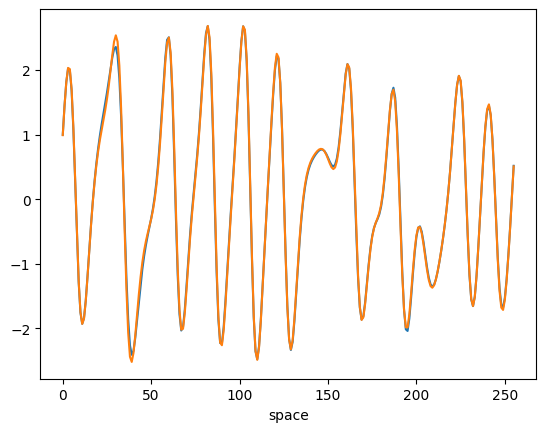

In [103]:
plt.plot(train_data[30,:,1,:].T)
plt.xlabel('space')

# Para adicionar valores constantes a cada Conjunto de Curvas (par de curvas) deve-se fazer o seguinte: adicionar uma dimensão no final 
# do array de 256 e preencher com os termos constantes. Exemplo: Se forem 3 constantes, o array de 256 passa a ser de 259. Tratar os dados no 
# dataloader para retornar os 256 valores para a targetnet e os 3 valores para a hypernet.

# train_data = jnp.concatenate([train_data, jnp.ones((train_data.shape[0], 1, 1, train_data.shape[-1]))], axis=2)

## Residual Neural Network

In [104]:
from typing import Callable

class ResBlockPostActivationPeriodic1d(eqx.Module):
    conv_1: eqx.nn.Conv1d # This is the first convolutional layer
    conv_2: eqx.nn.Conv1d # This is the second convolutional layer
    activation: Callable # This is the activation function, and the Callable type is a function that returns a value

    def __init__(
        self,
        hidden_channels: int,
        activation: Callable,
        *, # This is a separator to indicate that the following arguments are keyword-only
        key,
    ):
        c_1_key, c_2_key = jax.random.split(key)

        # Requires an up-to-dat version of Equinox
        self.conv_1 = eqx.nn.Conv1d( # This is the first convolutional layer
            hidden_channels, # This is the number of input channels
            hidden_channels, # This is the number of output channels
            kernel_size=2, # This is the kernel size, it means that the convolutional layer will use 3 points to make the convolution
            padding="SAME", # This is the padding, it means that the convolutional layer will use the same size of the input
            padding_mode="CIRCULAR", # This is the padding mode, it means that the convolutional layer will use the circular padding
            key=c_1_key 
        )
        self.conv_2 = eqx.nn.Conv1d(
            hidden_channels,
            hidden_channels,
            kernel_size=2,
            padding="SAME",
            padding_mode="CIRCULAR",
            key=c_2_key
        )

        self.activation = activation

    def __call__(
        self,
        x,
    ):
        x_skip = x
        x = self.conv_1(x)
        x = x + x_skip # Residual connection
        x = self.activation(x)
        x = self.conv_2(x)
        x = x + x_skip # Residual connection
        x = self.activation(x)

        return x
    
    def get_params(self):
        return [self.conv_1.weight,
                self.conv_1.bias, 
                self.conv_2.weight, 
                self.conv_2.bias]


In [106]:
class ResNetPeriodic1d(eqx.Module):
    lifting: eqx.nn.Conv1d # This is the first layer, the lifting layer that maps the input to the hidden space of the network with upper dimension
    blocks: list[ResBlockPostActivationPeriodic1d] # This is the list of the ResNet blocks that will be used in the network.
    projection: eqx.nn.Conv1d # This is another 1D convolutional layer with kernel size 1, which projects the final transformed data back to a lower-dimensional space.

    def __init__(
        self,
        hidden_channels,
        num_blocks,
        activation,
        *,
        key,
    ):
        l_key, *block_keys, p_key = jax.random.split(key, num_blocks+2)

        self.lifting = eqx.nn.Conv1d(1, hidden_channels, kernel_size=1, key=l_key)
        self.blocks = [
            ResBlockPostActivationPeriodic1d(hidden_channels, activation, key=k)
            for k in block_keys
        ]
        self.projection = eqx.nn.Conv1d(hidden_channels, 1, kernel_size=1, key=p_key)

    def __call__(self, x):
        x = self.lifting(x)
        for block in self.blocks:
            x = block(x)
        x = self.projection(x)

        return x
    
    def get_params_tree(self):
        # Retorna os parâmetros das camadas
        lifting_params = [
            self.lifting.weight,
            self.lifting.bias
        ]

        block_params = [block.get_params() for block in self.blocks]
        
        projection_params = [
            self.projection.weight,
            self.projection.bias
            ]

        return [
            lifting_params,
            block_params,
            projection_params
        ]


In [107]:
import equinox as eqx
import jax.numpy as jnp
from optax import adagrad

model = ResNetPeriodic1d(hidden_channels=1, num_blocks=1, activation=jax.nn.relu, key=jax.random.PRNGKey(42))

def is_array(x):
    return isinstance(x, jnp.ndarray)

array_parts = eqx.filter(model, eqx.is_array)
optimizer = optax.adagrad(0.001)
opt_state = optimizer.init(array_parts)
opt_state

(ScaleByRssState(sum_of_squares=ResNetPeriodic1d(
   lifting=Conv1d(
     num_spatial_dims=1,
     weight=f32[1,1,1],
     bias=f32[1,1],
     in_channels=1,
     out_channels=1,
     kernel_size=(1,),
     stride=(1,),
     padding=((0, 0),),
     dilation=(1,),
     groups=1,
     use_bias=True,
     padding_mode='ZEROS'
   ),
   blocks=[
     ResBlockPostActivationPeriodic1d(
       conv_1=Conv1d(
         num_spatial_dims=1,
         weight=f32[1,1,2],
         bias=f32[1,1],
         in_channels=1,
         out_channels=1,
         kernel_size=(2,),
         stride=(1,),
         padding='SAME',
         dilation=(1,),
         groups=1,
         use_bias=True,
         padding_mode='CIRCULAR'
       ),
       conv_2=Conv1d(
         num_spatial_dims=1,
         weight=f32[1,1,2],
         bias=f32[1,1],
         in_channels=1,
         out_channels=1,
         kernel_size=(2,),
         stride=(1,),
         padding='SAME',
         dilation=(1,),
         groups=1,
         use_

In [117]:
def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the data. The data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)

        yield sub_data

loader =  dataloader(train_data, batch_size=20, key= jax.random.PRNGKey(42))

for batch in loader:
    print(batch[:, 0].shape)

(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)
(20, 1, 256)

In [122]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
from tqdm import tqdm

# Definindo variáveis
HIDDEN_CHANNELS = 2
NUM_BLOCKS = 2
ACTIVATION = jax.nn.relu
INIT_SEED = 42
LEARNING_RATE = 3e-4
SHUFFLE_SEED = 99
NUM_EPOCHS = 15
BATCH_SIZE = 20

# Inicializando a rede e o otimizador
ks_res_net_emulator = ResNetPeriodic1d(HIDDEN_CHANNELS, NUM_BLOCKS, ACTIVATION, key=jax.random.PRNGKey(INIT_SEED))
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(ks_res_net_emulator, eqx.is_array))

# Função de perda
def loss_fn(model, batch):
    x, y = batch[:, 0], batch[:, 1]
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse

# Função de atualização do modelo
@eqx.filter_jit
def step_fn(model, state, batch):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, batch)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

# Inicializando variáveis de histórico
shuffle_key = jax.random.PRNGKey(SHUFFLE_SEED)
train_loss_history = []
param_history = []  # Para armazenar o histórico dos parâmetros achatados

# Loop de treinamento
for epoch in tqdm(range(NUM_EPOCHS)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in tqdm(dataloader(train_data, batch_size=BATCH_SIZE, key=subkey)):
        ks_res_net_emulator, opt_state, loss = step_fn(ks_res_net_emulator, opt_state, batch)

        # Salvar a perda do treinamento
        train_loss_history.append(loss)

    print('Avg Loss: ', jnp.mean(loss))


300it [00:02, 139.13it/s]:00<?, ?it/s]
  7%|▋         | 1/15 [00:02<00:30,  2.16s/it]

Avg Loss:  0.7740942


300it [00:01, 229.34it/s]
 13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Avg Loss:  0.5553509


300it [00:01, 229.93it/s]
 20%|██        | 3/15 [00:04<00:17,  1.50s/it]

Avg Loss:  0.4910941


300it [00:01, 217.79it/s]
 27%|██▋       | 4/15 [00:06<00:15,  1.45s/it]

Avg Loss:  0.40034667


300it [00:01, 231.91it/s]
 33%|███▎      | 5/15 [00:07<00:13,  1.40s/it]

Avg Loss:  0.34293288


300it [00:01, 227.05it/s]
 40%|████      | 6/15 [00:08<00:12,  1.37s/it]

Avg Loss:  0.29841796


300it [00:01, 233.48it/s]
 47%|████▋     | 7/15 [00:10<00:10,  1.34s/it]

Avg Loss:  0.24257933


300it [00:01, 232.21it/s]
 53%|█████▎    | 8/15 [00:11<00:09,  1.33s/it]

Avg Loss:  0.24364701


300it [00:01, 236.75it/s]
 60%|██████    | 9/15 [00:12<00:07,  1.31s/it]

Avg Loss:  0.21892944


300it [00:01, 235.53it/s]
 67%|██████▋   | 10/15 [00:13<00:06,  1.30s/it]

Avg Loss:  0.16099226


300it [00:01, 223.44it/s]
 73%|███████▎  | 11/15 [00:15<00:05,  1.31s/it]

Avg Loss:  0.1546377


300it [00:01, 230.51it/s]
 80%|████████  | 12/15 [00:16<00:03,  1.31s/it]

Avg Loss:  0.123249784


300it [00:01, 235.07it/s]
 87%|████████▋ | 13/15 [00:17<00:02,  1.30s/it]

Avg Loss:  0.117689624


300it [00:01, 236.03it/s]
 93%|█████████▎| 14/15 [00:19<00:01,  1.29s/it]

Avg Loss:  0.10612718


300it [00:01, 233.31it/s]
100%|██████████| 15/15 [00:20<00:00,  1.36s/it]

Avg Loss:  0.08119835


In [60]:
param_history[1].shape

(176,)

Text(0, 0.5, 'Loss')

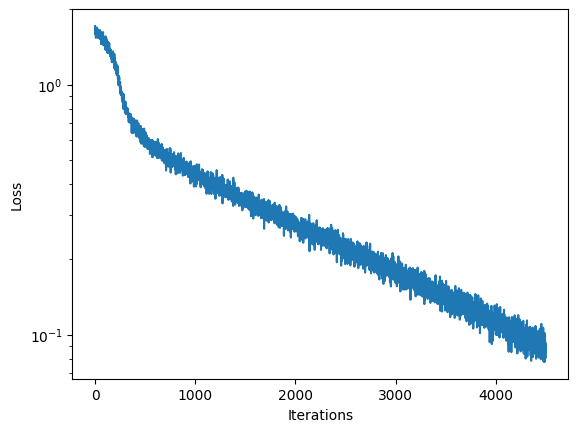

In [123]:
plt.semilogy(train_loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')

# testes